In [1]:
import pandas as pd

df = pd.read_csv("C:\\Users\\hoi\\Desktop\\SAT revw\\coursera_dataset_cleaned.csv")

# Drop existing success_score
if 'success_score' in df.columns:
    df.drop(columns='success_score', inplace=True)

In [2]:

df['rating'] = df['rating'].fillna(0)
df['students_enrolled'] = df['students_enrolled'].fillna(0)
df['reviews_count'] = df['reviews_count'].fillna(0)

# Fill missing categorical values with 'Unknown'
df['category'] = df['category'].fillna('Unknown')
df['difficulty_level'] = df['difficulty_level'].fillna('Unknown')

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['rating_norm', 'enrolled_norm', 'reviews_norm']] = scaler.fit_transform(
    df[['rating', 'students_enrolled', 'reviews_count']]
)

# Weighted composite score
df['success_score'] = (
    0.5 * df['rating_norm'] +
    0.3 * df['enrolled_norm'] +
    0.2 * df['reviews_norm']
)

In [4]:

df['price_bucket'] = pd.cut(df['price_usd'], bins=[-1, 0, 50, 200, 1000],
                            labels=['Free', 'Low', 'Mid', 'High'])

# Instructor popularity proxy
df['instructor_popularity'] = df['reviews_count'] / (df['students_enrolled'] + 1)

In [5]:
df = pd.get_dummies(df, columns=['category', 'difficulty_level', 'price_bucket'], drop_first=True)

In [6]:
X = df.drop(columns=['course_title', 'enrollment_id', 'platform', 'instructor_profile', 'success_score'])
y = df['success_score']

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# RMSE (manual square root of MSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R² Score:", r2)

RMSE: 0.008516672882032584
R² Score: 0.9897342495436554


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Features and target
X = df.drop(columns=['course_title', 'enrollment_id', 'platform',
                     'instructor_profile', 'success_score'])
y = df['success_score']

# Model
model = RandomForestRegressor(random_state=42)

# R² scores across 5 folds
r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("R² scores:", r2_scores)
print("Mean R²:", np.mean(r2_scores))

# RMSE across 5 folds
rmse_scores = cross_val_score(model, X, y, cv=5,
                              scoring='neg_root_mean_squared_error')
print("RMSE scores:", -rmse_scores)
print("Mean RMSE:", -np.mean(rmse_scores))

R² scores: [0.96792624 0.98873961 0.99753922 0.99821189 0.99693566]
Mean R²: 0.9898705227146486
RMSE scores: [0.02527565 0.0106509  0.00204272 0.00158907 0.00237821]
Mean RMSE: 0.008387309681106094


In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor


X = df.drop(columns=['course_title', 'enrollment_id', 'platform',
                     'instructor_profile', 'success_score'])
y = df['success_score']


models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "LinearRegression": LinearRegression(),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, n_estimators=200, learning_rate=0.1)
}


results = {}
for name, model in models.items():
    r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    rmse_scores = cross_val_score(model, X, y, cv=5,
                                  scoring='neg_root_mean_squared_error')
    
    results[name] = {
        "R² mean": np.mean(r2_scores),
        "R² std": np.std(r2_scores),
        "RMSE mean": -np.mean(rmse_scores),
        "RMSE std": np.std(-rmse_scores)
    }


pd.DataFrame(results).T

,R² mean,R² std,RMSE mean,RMSE std
RandomForest,0.989871,0.011499,8.387310e-03,9.087562e-03
LinearRegression,1.000000,0.000000,1.184646e-12,1.173194e-12
GradientBoosting,0.992270,0.001194,6.445876e-03,3.969931e-03
XGBoost,0.993153,0.004928,6.640507e-03,6.039154e-03


C:\Users\hoi\AppData\Local\Temp\ipykernel_10788\3682507053.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette="viridis")


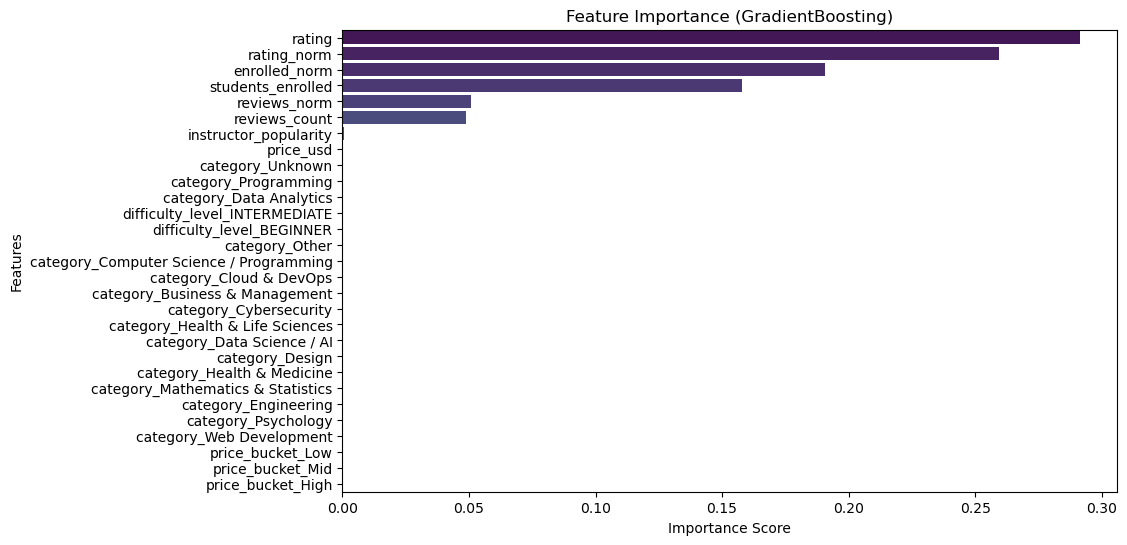

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor

# Fit GradientBoosting on full dataset
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X, y)

# Extract feature importances
feature_importances = pd.Series(gb_model.feature_importances_, index=X.columns)

# Sort for better visualization
feature_importances = feature_importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances, y=feature_importances.index, palette="viridis")
plt.title("Feature Importance (GradientBoosting)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X, y)

print("Train R²:", gb_model.score(X, y))

Train R²: 0.9965086341501138


In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],       # number of boosting stages
    'learning_rate': [0.05, 0.1, 0.2],     # shrinkage rate
    'max_depth': [3, 5, 7],                # depth of individual trees
    'min_samples_split': [2, 5, 10],       # minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]          # minimum samples per leaf
}

grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best CV R² Score:", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best CV R² Score: 0.9961898213327336


C:\Users\hoi\AppData\Local\Temp\ipykernel_10788\1924871974.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette="viridis")


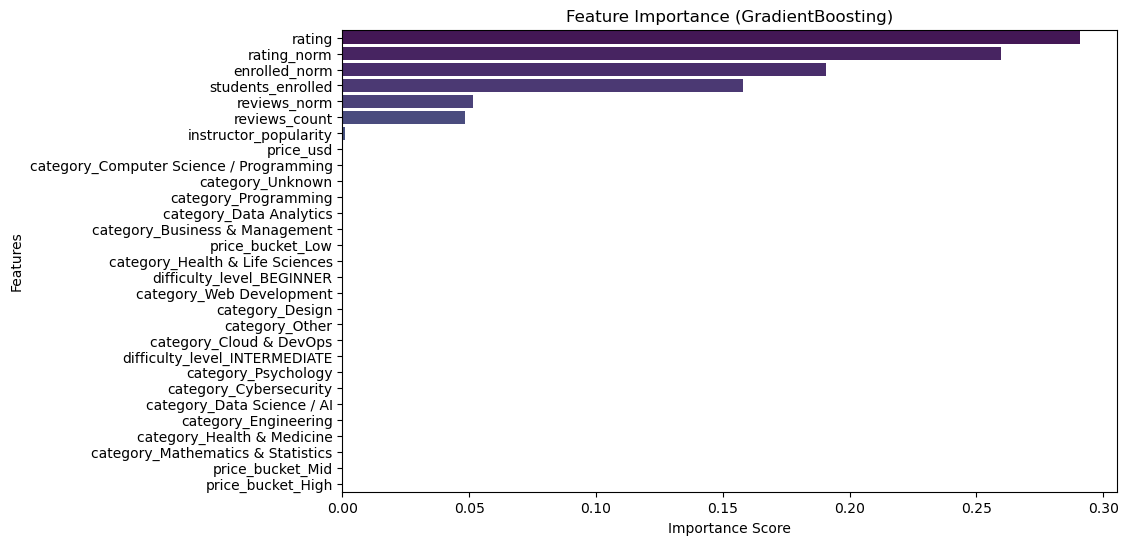

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Use the tuned model if available
best_gb = grid_search.best_estimator_

feature_importances = pd.Series(best_gb.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances, y=feature_importances.index, palette="viridis")
plt.title("Feature Importance (GradientBoosting)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()